# Images and convolutional networks

In this notebook, we will dig deeper into convolutional neural networks for image classification.

## Filter visualization

We will first try to visualize what these networks learn, _i.e._ what kind of local patterns their convolution blocks typically detect.
For this exercise, we will focus on the first layer of these models to keep the maths simple.

**Question 1.** Suppose a model has learned a convolution filter (_aka_ kernel) $W$ and a bias $b$.
What is (theoretically) the unit-norm image patch $P$ that maximizes the ouput activation for 
this specific configuration:

$$\max_{P} \varphi(W \cdot P + b)) \text{ such that } \|P\| = 1$$

where $\varphi$ is the activation function, for which our only assumption will be that it is an non-decreasing function.

Write your (text) answer here.

**Question 2.** Given your answer above, and the model fit below, visualize, for each filter of the first convolutional 
layer, the input patch that would correspond to maximum activation.
See [`keras` docs](https://keras.io/api/layers/) for more information on how to access weights of 
a given layer.

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

def prepare_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.
    x_test = x_test / 255.
    x_train = x_train.reshape((-1, 28, 28, 1))
    x_test = x_test.reshape((-1, 28, 28, 1))
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_mnist()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense

first_conv_layer = Conv2D(filters=5, kernel_size=5, padding='valid', activation="relu")

model = Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    first_conv_layer,
    MaxPool2D(pool_size=2),
    Conv2D(filters=10, kernel_size=5, padding='valid', activation="relu"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(units=10, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=100, validation_data=(x_test, y_test))

Epoch 1/5
600/600 [==============================] - 26s 44ms/step - loss: 0.4816 - accuracy: 0.8573 - val_loss: 0.1839 - val_accuracy: 0.9441
Epoch 2/5
600/600 [==============================] - 25s 41ms/step - loss: 0.1595 - accuracy: 0.9514 - val_loss: 0.1115 - val_accuracy: 0.9670
Epoch 3/5
600/600 [==============================] - 24s 41ms/step - loss: 0.1157 - accuracy: 0.9651 - val_loss: 0.0897 - val_accuracy: 0.9718
Epoch 4/5
600/600 [==============================] - 24s 40ms/step - loss: 0.0953 - accuracy: 0.9707 - val_loss: 0.0787 - val_accuracy: 0.9752
Epoch 5/5
600/600 [==============================] - 24s 40ms/step - loss: 0.0824 - accuracy: 0.9750 - val_loss: 0.0695 - val_accuracy: 0.9787


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# TODO

**Question 3.** Repeat this process for the pre-trained ResNet50 model you used in the previous
lab session.
Visualize the first 16 filters of the first convolutional layer.

# Adversarial examples

In this section, we will illustrate the concept of adversarial examples and implement a simple 
[fast-sign-gradient method](https://arxiv.org/abs/1412.6572) to generate such examples.
The idea of this method is the following:

Suppose we denote by $\mathcal{L}(x, y; \theta)$ the loss function (typically categorical cross-entropy) evaluated for
the current parameters $\theta$ of a model on a single example $(x, y)$.
If we compute the gradient of $\mathcal{L}$ **with respect to $x$**, it will give us the direction of 
steepest increase 
of $\mathcal{L}$, hence the the direction that is most likely to increase $\mathcal{L}$ if we perform a small modification on $x$ (not on model parameters, as we usually do when our goal is to fit a model).
Hence if we push $x$ (which is an image here) in that direction, we will perform a gradient ascent on $x$, 
which means we will change its pixel content in order to fool the 
classifier.
If we are able to fool the classifier even with small changes, we have successfully generated an adversarial example: an 
example that is generated on purpose to look easy to classify for a human eye, but still fool the classifier.

More precisely the update rule for the fast-sign-gradient method is:

$$x^{(t+1)} = x^{(t)}+ \eta \, \text{sign}(\nabla_x\mathcal{L}(x^{(t)}, y; \theta))$$

where $\eta$ is a gradient step (or learning rate).

Note that an alternative way to use this fast-sign-gradient method would be to perform a gradient descent (not ascent, this time)
on the quantity $\mathcal{L}(x, y^\prime; \theta)$ where $y^\prime$ is a target class that we want the classifier to predict.

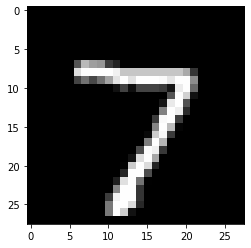

In [ ]:
img = x_test[0]

plt.imshow(img, cmap='gray')
label = y_test[0]

**Question 3.** For the first sample in the MNIST test set (plotted just above ⬆️), what is the probability assigned by
the simple model (made of 2 convolutional layers) defined above to **the correct class**?

In [ ]:
def predict_single_image(model, x):
    return model(x[None]).numpy()[0]

preds = predict_single_image(model, img)
# TODO

**Question 4.** The code below adds white noise to the image. See how this impacts (or not) the prediction quality of 
the model on this sample. You can play with the level of white noise to better visualize the robustness of the model to this 
kind of content modification.

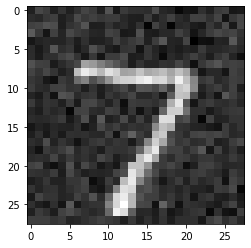

In [ ]:
noisy_image = img + .1 * np.random.randn(*img.shape)
plt.imshow(noisy_image, cmap='gray')

# TODO

**Question 5.** The function `sign_grad` below computes the quantity $\text{sign}(\nabla_x\mathcal{L}(x^{(t)}, y; \theta))$.
Using calls to this function, iteratively change the content of the non-noisy image to generate an adversarial example.
You can use a gradient step of .1 and 5 iterations should be sufficient.


In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

def sign_grad(model, image, label):
    image = tf.cast(image, tf.float32)

    image_batch = image[None]
    label_batch = label[None]
    
    with tf.GradientTape() as tape:
        tape.watch(image_batch)
        prediction = model(image_batch)
        loss = CategoricalCrossentropy()(label_batch, prediction)
    
    gradient = tape.gradient(loss, image_batch)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad[0]


num_iter = 5
eta = .1

# TODO

**Question 6.** Adapt your code above to push the model towards classifying the image into a 2.

In [ ]:
from tensorflow.keras.utils import to_categorical

img = x_test[0]
target_label = to_categorical(2, num_classes=10)

# TODO

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4418dda1-7b27-41aa-8376-9ca7c94fae59' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>